In [1]:
# Step 1: Import Libraries
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Step 2: Setup and Download Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d primaryobjects/voicegender

Dataset URL: https://www.kaggle.com/datasets/primaryobjects/voicegender
License(s): CC-BY-NC-SA-4.0
  0% 0.00/405k [00:00<?, ?B/s]
100% 405k/405k [00:00<00:00, 857MB/s]


In [3]:
with zipfile.ZipFile('/content/voicegender.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Correct path
df = pd.read_csv("voice.csv")

# Fit scaler
X = df.drop("label", axis=1)
scaler = StandardScaler()
scaler.fit(X)

# Save scaler for later use
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

✅ Scaler saved as scaler.pkl


In [5]:
def load_audio(file_path):
    audio = tf.io.read_file(file_path)
    waveform, _ = tf.audio.decode_wav(audio, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)
    return waveform

In [6]:
def pad_or_trim(waveform, target_len=16000):
    waveform_len = tf.shape(waveform)[0]
    if waveform_len < target_len:
        padding = target_len - waveform_len
        waveform = tf.pad(waveform, [[0, padding]])
    else:
        waveform = waveform[:target_len]
    return waveform

In [7]:
def get_spectrogram(waveform):
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(stft)
    spectrogram = tf.expand_dims(spectrogram, -1)  # shape: (time, freq, 1)
    return spectrogram

In [8]:
def add_noise(waveform, noise_factor=0.005):
    noise = tf.random.normal(shape=tf.shape(waveform), mean=0.0, stddev=1.0)
    return waveform + noise_factor * noise

In [9]:
def time_shift(waveform, shift_max=1000):
    shift = tf.random.uniform([], -shift_max, shift_max, dtype=tf.int32)
    return tf.roll(waveform, shift=shift, axis=0)

In [10]:
def apply_time_mask(spectrogram, mask_param=10):
    time_max = tf.shape(spectrogram)[0]
    t = tf.random.uniform([], minval=0, maxval=mask_param, dtype=tf.int32)
    t0 = tf.random.uniform([], 0, time_max - t, dtype=tf.int32)
    mask = tf.concat([
        spectrogram[:t0],
        tf.zeros_like(spectrogram[t0:t0 + t]),
        spectrogram[t0 + t:]
    ], axis=0)
    return mask

In [11]:
def preprocess(file_path, label):
    waveform = load_audio(file_path)
    waveform = pad_or_trim(waveform)

    # Augment
    waveform = add_noise(waveform)
    waveform = time_shift(waveform)

    # Convert to spectrogram
    spectrogram = get_spectrogram(waveform)

    # Spectrogram augmentation (optional)
    spectrogram = apply_time_mask(spectrogram)

    return spectrogram, label

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
# Load CSV
df = pd.read_csv('voice.csv')

# Encode label
df['label'] = LabelEncoder().fit_transform(df['label'])  # male=1, female=0

# Features and target
X = df.drop('label', axis=1).values
y = df['label'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))



In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    BatchNormalization(),  # ✅ helps with training stability
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6599 - loss: 0.7301 - val_accuracy: 0.8959 - val_loss: 0.3559
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8489 - loss: 0.3472 - val_accuracy: 0.9416 - val_loss: 0.2181
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9064 - loss: 0.2467 - val_accuracy: 0.9669 - val_loss: 0.1341
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9374 - loss: 0.1786 - val_accuracy: 0.9795 - val_loss: 0.0898
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9416 - loss: 0.1635 - val_accuracy: 0.9811 - val_loss: 0.0740
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9453 - loss: 0.1676 - val_accuracy: 0.9811 - val_loss: 0.0649
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9498 - loss: 0.1469 - val_accuracy: 0.9826 - val_loss: 0.0625
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9545 - loss: 0.1208 - val_accuracy: 0.9795 - val_loss: 0.

In [40]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,141 (43.52 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,300 (28.52 KB)

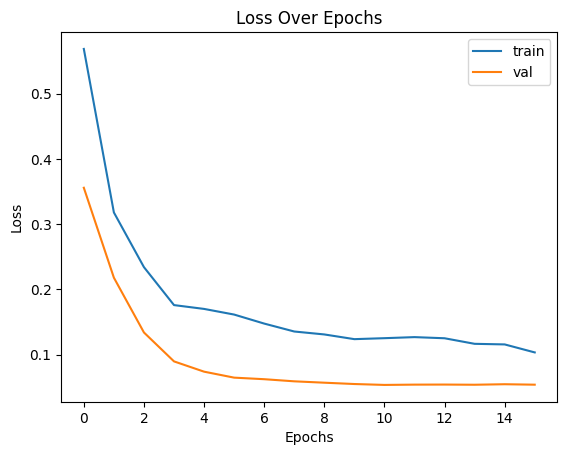

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

# Save as pre-trained model
model.save('voice_gender_model.h5')


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9789 - loss: 0.0566 


Test Accuracy: 0.98


In [47]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       297
           1       0.99      0.98      0.98       337

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



In [43]:
model = tf.keras.models.load_model('voice_gender_model.h5')

# Predict new samples
import numpy as np
sample = np.expand_dims(X_test[0], axis=0)
prediction = model.predict(sample)
print("Predicted Gender:", "Male" if prediction > 0.5 else "Female")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted Gender: Female


In [ ]:
#!pip install librosa soundfile scikit-learn joblib tensorflow

In [ ]:
#!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.1 MB/s eta 0:00:00


In [50]:
from google.colab import files
uploaded = files.upload()

Saving picnic-blanket-dreams-345364.mp3 to picnic-blanket-dreams-345364.mp3


In [26]:
#!pip install pydub

In [22]:
from pydub import AudioSegment

mp3_filename = "faudio.mp3"
wav_filename = "faudio.wav"

audio = AudioSegment.from_mp3(mp3_filename)
audio.export(wav_filename, format="wav")

<_io.BufferedRandom name='faudio.wav'>

In [30]:
import librosa
import numpy as np

def extract_full_features(faudio):
    y, sr = librosa.load(faudio, sr=None)

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    zero_crossings = librosa.zero_crossings(y)
    entropy = -np.sum((y ** 2) * np.log2(y ** 2 + 1e-6)) / len(y)

    features = [
        np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),      # meanfreq
        np.std(y),                                                  # sd
        np.median(y),                                               # median
        np.percentile(y, 25),                                       # Q25
        np.percentile(y, 75),                                       # Q75
        np.percentile(y, 75) - np.percentile(y, 25),                # IQR
        np.mean((y - np.mean(y))**3) / (np.std(y)**3 + 1e-6),       # skew
        np.mean((y - np.mean(y))**4) / (np.std(y)**4 + 1e-6),       # kurt
        entropy,                                                    # sp.ent
        np.mean(librosa.feature.spectral_flatness(y=y)),           # sfm
        np.mean(y),                                                 # mode (approx.)
        np.mean(centroid),                                          # centroid
        np.max(np.abs(y)),                                          # peakf
        np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),    # meanfun
        np.min(librosa.feature.spectral_centroid(y=y, sr=sr)),     # minfun
        np.max(librosa.feature.spectral_centroid(y=y, sr=sr)),     # maxfun
        np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),   # meandom
        np.min(librosa.feature.spectral_bandwidth(y=y, sr=sr)),    # mindom
        np.max(librosa.feature.spectral_bandwidth(y=y, sr=sr)),    # maxdom
        np.max(librosa.feature.spectral_bandwidth(y=y, sr=sr)) -
        np.min(librosa.feature.spectral_bandwidth(y=y, sr=sr))     # dfrange
    ]

    return np.array(features).reshape(1, -1)


In [32]:
features = extract_full_features("faudio.wav")
features_scaled = scaler.transform(features)
pred = model.predict(features_scaled)[0][0]
gender = "Male" if pred > 0.5 else "Female"
print(f"🎤 Gender Prediction: {gender} (Confidence: {pred:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🎤 Gender Prediction: Male (Confidence: 1.00)


In [51]:
import librosa
import numpy as np
import joblib
from pydub import AudioSegment
from tensorflow.keras.models import load_model
import os

# 🔁 Convert MP3 to WAV (since librosa loads WAV better)
def convert_mp3_to_wav(mp3_path, wav_path="converted.wav"):
    sound = AudioSegment.from_mp3(mp3_path)
    sound.export(wav_path, format="wav")
    return wav_path

# 🎯 Feature extractor (must match training features from voice.csv)
def extract_features(wav_path):
    y, sr = librosa.load(wav_path)
    meanfreq = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    sd = np.std(y)
    median = np.median(y)
    Q25 = np.percentile(y, 25)
    Q75 = np.percentile(y, 75)
    IQR = Q75 - Q25
    skew = np.mean((y - np.mean(y))**3) / (np.std(y)**3 + 1e-6)
    kurt = np.mean((y - np.mean(y))**4) / (np.std(y)**4 + 1e-6)
    sp_ent = -np.sum((y**2) * np.log2(y**2 + 1e-6)) / len(y)
    sfm = np.mean(librosa.feature.spectral_flatness(y=y))
    mode = np.mean(y)  # Approximation
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    peakf = np.max(np.abs(y))
    meanfun = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    minfun = np.min(librosa.feature.spectral_centroid(y=y, sr=sr))
    maxfun = np.max(librosa.feature.spectral_centroid(y=y, sr=sr))
    meandom = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    mindom = np.min(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    maxdom = np.max(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    dfrange = maxdom - mindom

    return np.array([[meanfreq, sd, median, Q25, Q75, IQR, skew, kurt,
                      sp_ent, sfm, mode, centroid, peakf, meanfun,
                      minfun, maxfun, meandom, mindom, maxdom, dfrange]])

# 📤 Upload your file in Colab (from Files panel or use upload tool)
# Example filename:
mp3_path = "/content/picnic-blanket-dreams-345364.mp3"

# 🔁 Convert to wav
wav_path = convert_mp3_to_wav(mp3_path)

# ✅ Load scaler and model
scaler = joblib.load("scaler.pkl")              # You must have this saved
model = load_model("voice_gender_model.h5")            # Your trained model

# 🎯 Predict
features = extract_features(wav_path)
features_scaled = scaler.transform(features)
prediction = model.predict(features_scaled)

# 🧠 Output
gender = "Male" if prediction[0][0] > 0.5 else "Female"
print(f"Predicted gender: {gender}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted gender: Male


In [49]:
prob = model.predict(features_scaled)[0][0]
print("Model raw probability:", prob)
print("Predicted gender:", "Male" if prob > 0.5 else "Female")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model raw probability: 1.0
Predicted gender: Male
